# Tohoku tsunami inversion

Just consider gauges P02, P06 and 801-807 over a 30 minute window. Check that we can accurately compute the gradient w.r.t. a (mesh-dependent) source field.

In [1]:
%matplotlib inline

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
from adapt_utils.case_studies.tohoku.options.options import TohokuInversionOptions
from adapt_utils.misc import gaussian, ellipse

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

### Forward model

In [6]:
level = 0
op = TohokuInversionOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0','80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())
print(gauges)
op.end_time = 60*30

['801', '802', '803', '804', '806', '807', 'P02', 'P06']


In [7]:
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
TaylorHood = P2_vec*P1

In [8]:
b = Function(P1).assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1).assign(op.set_coriolis(P1))

In [9]:
boundary_conditions = {100: ['freeslip', 'dirichlet'], 200: ['freeslip'], 300: ['freeslip']}

In [10]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)
q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

n = FacetNormal(mesh)

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    for tag in boundary_conditions:
        if "freeslip" not in boundary_conditions[tag]:
            F += inner(zeta*n, b*uv)*ds(tag)
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()

bcs = []
for tag in boundary_conditions:
    if "dirichlet" in boundary_conditions[tag]:
        bcs.append(DirichletBC(TaylorHood.sub(1), 0, tag))

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bcs)
solver = LinearVariationalSolver(problem, solver_parameters=params)

# Source model

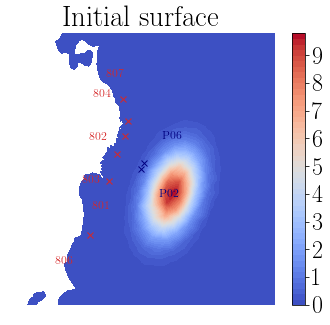

In [11]:
with stop_annotating():  # NOTE: VERY IMPORTANT!
    q0 = Function(TaylorHood)
    u0, eta0 = q0.split()
    loc = (0.7e+06, 4.2e+06)
    radii = (48e+03, 96e+03)
    angle = pi/12
    eta0.interpolate(10*gaussian([loc + radii], mesh, rotation=angle))
#     eta0.interpolate(gaussian([loc + radii], mesh, rotation=angle))
    
    eta0.dat.name = "Initial surface"
    axes = plot_field(eta0);
    xg, yg = op.gauges["P02"]["coords"]
    axes.set_xlim([xg - 0.3e+06, xg + 0.3e+06]);
    axes.set_ylim([yg - 0.35e+06, yg + 0.35e+06]);
    op.annotate_plot(axes)

q_init = Function(TaylorHood)
q_init.project(q0);
    
# R = FunctionSpace(mesh, "R", 0)
# m = Function(R).assign(10.0)
# q_init.project(m*q0);

## Forward solve

Now run the forward model, time integrating the QoI as time progresses.

In [12]:
def solve_forward(init):
    q_.assign(init)
    
    for gauge in gauges:
        op.gauges[gauge]['init'] = Constant(eta_.at(op.gauges[gauge]['coords']))

    t = 0.0
    iteration = 0
    J = 0
    wq = Constant(1.0)
    eta_obs = Constant(0.0)
    while t < op.end_time:

        # Solve forward equation at current timestep
        solver.solve()

        # Time integrate QoI
        for gauge in op.gauges:
            if t < op.gauges[gauge]['arrival_time']:
                continue
            elif np.isclose(t, op.gauges[gauge]['arrival_time']):
                wq.assign(0.5*0.5*op.dt)
            elif np.isclose(t, op.gauges[gauge]['departure_time']):
                wq.assign(0.5*0.5*op.dt)
            elif t > op.gauges[gauge]['departure_time']:
                continue
            else:
                wq.assign(0.5*1.0*op.dt)
                
            # Interpolate observations
            eta_obs.assign(float(op.gauges[gauge]['interpolator'](t)))

            # Continuous form of error
            I = op.gauges[gauge]['indicator']
            J = J + assemble(wq*I*(eta - eta_obs - op.gauges[gauge]['init'])**2*dx)

        # Increment
        q_.assign(q)
        t += op.dt
        iteration += 1

    assert np.allclose(t, op.end_time), "mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time)
    return J

Define gauge indicators

In [13]:
gauges = list(op.gauges.keys())
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
P0 = FunctionSpace(mesh, "DG", 0)
for gauge in gauges:
    loc = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([loc + (radius,)], mesh), P0)
    area = assemble(op.gauges[gauge]['indicator']*dx)
    op.gauges[gauge]['indicator'].assign(op.gauges[gauge]['indicator']/area)

In [14]:
times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for gauge in gauges:
    op.sample_timeseries(gauge, sample=op.gauges[gauge]['sample'], detide=True)

In [15]:
J = solve_forward(q_init)
print("Quantity of interest = {:.4e}".format(J))

Quantity of interest = 2.2487e+04


## Discrete adjoint

Note that we only Taylor test the elevation and effectively zero out the perturbation away from the source.

In [16]:
c = Control(q_init)
# c = Control(m)

In [17]:
stop_annotating();

In [18]:
tape = get_working_tape()
for i, block in enumerate(tape._blocks):
    print(i, type(block))

0 <class 'firedrake.adjoint.blocks.InterpolateBlock'>
1 <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
2 <class 'firedrake.adjoint.blocks.InterpolateBlock'>
3 <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
4 <class 'firedrake.adjoint.blocks.ProjectBlock'>
5 <class 'firedrake.adjoint.blocks.InterpolateBlock'>
6 <class 'firedrake.adjoint.blocks.AssembleBlock'>
7 <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
8 <class 'firedrake.adjoint.blocks.InterpolateBlock'>
9 <class 'firedrake.adjoint.blocks.AssembleBlock'>
10 <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
11 <class 'firedrake.adjoint.blocks.InterpolateBlock'>
12 <class 'firedrake.adjoint.blocks.AssembleBlock'>
13 <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
14 <class 'firedrake.adjoint.blocks.InterpolateBlock'>
15 <class 'firedrake.adjoint.blocks.AssembleBlock'>
16 <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
17 <class 'firedrake.adjoint.blocks.InterpolateBlock'>
18 <class 'firedra

632 <class 'firedrake.adjoint.blocks.AssembleBlock'>
633 <class 'pyadjoint.adjfloat.AddBlock'>
634 <class 'firedrake.adjoint.blocks.ConstantAssignBlock'>
635 <class 'firedrake.adjoint.blocks.ConstantAssignBlock'>
636 <class 'firedrake.adjoint.blocks.FunctionSplitBlock'>
637 <class 'firedrake.adjoint.blocks.AssembleBlock'>
638 <class 'pyadjoint.adjfloat.AddBlock'>
639 <class 'firedrake.adjoint.blocks.ConstantAssignBlock'>
640 <class 'firedrake.adjoint.blocks.ConstantAssignBlock'>
641 <class 'firedrake.adjoint.blocks.FunctionSplitBlock'>
642 <class 'firedrake.adjoint.blocks.AssembleBlock'>
643 <class 'pyadjoint.adjfloat.AddBlock'>
644 <class 'firedrake.adjoint.blocks.ConstantAssignBlock'>
645 <class 'firedrake.adjoint.blocks.ConstantAssignBlock'>
646 <class 'firedrake.adjoint.blocks.FunctionSplitBlock'>
647 <class 'firedrake.adjoint.blocks.AssembleBlock'>
648 <class 'pyadjoint.adjfloat.AddBlock'>
649 <class 'firedrake.adjoint.blocks.ConstantAssignBlock'>
650 <class 'firedrake.adjoint.blo

In [19]:
Jhat = ReducedFunctional(J, c)

In [20]:
np.random.seed(0)
m0 = Function(TaylorHood).assign(q_init)
dm0 = Function(TaylorHood)
dm0.dat.data[1][:] = np.random.rand(*dm0.dat.data[1].shape)*m0.dat.data[1]
# dm0.dat.data[1][np.argmax(m0.dat.data[1])] = 0.01
# m0 = Function(R).assign(5.0)
# dm0 = Function(R).assign(1.0)
minconv = taylor_test(Jhat, m0, dm0)
assert minconv > 1.90, minconv

Running Taylor test
epsilon 1.0000e-02  residual 6.0522e-01
epsilon 5.0000e-03  residual 1.4498e-01
epsilon 2.5000e-03  residual 4.0245e-02
epsilon 1.2500e-03  residual 1.2302e-02
Computed residuals: [0.6052190602435843, 0.14498089235598144, 0.04024478074404314, 0.012302098805490047]
Computed convergence rates: [2.0615946493579034, 1.848989173331833, 1.7098972272079878]


AssertionError: 1.7098972272079878

In [ ]:
# from firedrake.adjoint.blocks import GenericSolveBlock

# solve_blocks = [block for block in tape._blocks if isinstance(block, GenericSolveBlock)]
# solve_blocks = [block for block in solve_blocks if block.adj_sol is not None]